# Exploring Connectome Gradients with Jaxley

Understanding neural connectomes is a fascinating frontier in neuroscience. As larger and more detailed connectome datasets become available, new computational techniques are required to make sense of complex interplay of connectivity and resulting neural dynamics. One promising tool are gradient-based optimization and analysis that are enabled by modern autodifferention libraries like Jax. For example, the Jax-based framework Jaxley allows building differentiable neural simulations, enabling new optimization and analysis approaches.  

This tutorial explores using differentiable neural simulation with connectome data.

Specifically, this tutorial walks through:

- Part 1: Model Specification in Jaxley (cells, channels, synapses), including custom Calcium channel and graded/differentiable synapse aligned with c302 C-level.
- Part 2: Connectome Translation from c302 NeuroML to a Jaxley network using `c302.neuroml_to_jaxley`.
- Part 3: Simulation, visualization, and a simple gradient-based optimization on network and stimulus parameters.

# Installation


Create or select a virtual environment
```sh
python -m venv .venv
```
and install the dependencies below:
```
jupyter 
ipykernel 
jax
jaxley
matplotlib
git+https://github.com/openworm/c302 
```

In [ ]:
import sys
!{sys.executable} -m pip install jax jaxley matplotlib git+https://github.com/openworm/c302

In [94]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import jaxley as jx
import jax.numpy as jnp

from custom_mechanisms import (
    VGCaChannel,
    GradedChemicalSynapse,
    DifferentiableExpTwoSynapse,
    GapJunctionSynapse,
)

from neuroml_to_jaxley import *
import matplotlib.pyplot as plt


## Part 1: Model Specification

Jaxley makes it straight-forward to define neural dynamics models.

Here, we will use the build-in HH (Na, K, Leak) channel and add:
- a minimal voltage-gated Ca channel (e+f gates) `VGCaChannel`
- a differentiable, C-like two-exponential chemical synapse `DifferentiableExpTwoSynapse`
- a simple gap junction synapse `GapJunctionSynapse`

These are defined in [custom_mechanisms.py](./custom_mechanisms.py).


## Internals: Modules and parameter names

- Cells/branches/compartments: `jx.Cell → jx.Branch → comp(index)`; global vs local scopes enable vectorized selection (`cell("all").branch(0)`).
- Channels: built-ins (HH) expose `HH_*` parameter names, e.g., `HH_gNa`, consistent with c302 mapping.
- Synapses:
  - IonotropicSynapse (built-in): `IonotropicSynapse_gS`, `IonotropicSynapse_e_syn`, `IonotropicSynapse_v_th`, `IonotropicSynapse_delta`, `IonotropicSynapse_k_minus`.
  - Custom `GradedChemicalSynapse` and `DifferentiableExpTwoSynapse` accept both their own keys and IonotropicSynapse aliases for compatibility with the translator.
- Gap junction: use built-in `GapJunction` when available; custom `GapJunctionSynapse` also accepts `GapJunction*_gGap` or bare `gGap`.


### Part 1.1: Create a demo cell and insert channels

We create a single-compartment cell and insert HH and a minimal Ca channel. This cell will be duplicated to form a 2-cell micro-network.


In [95]:
# Build a small demo cell with HH + VGCa
comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=1)
cell = jx.Cell(branch, parents=[-1])
cell.insert(jx.channels.HH())
cell.insert(VGCaChannel())


### Part 1.2: Build a 2-cell network and connect with a synapse

We duplicate the cell into a network with two cells and connect them using the differentiable two-exponential synapse.


In [96]:
# Build 2-cell network and connect
cells = [cell, cell]
net = jx.Network(cells)
pre = net.cell(0).branch(0).loc(0.0)
post = net.cell(1).branch(0).loc(0.0)

syn = DifferentiableExpTwoSynapse()
jx.connect(pre, post, syn)

# Record
net.cell(0).branch(0).loc(0.0).record()
net.cell(1).branch(0).loc(0.0).record()


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


### Part 1.3: Stimulate and simulate the micro-network

We inject a simple pulse into the presynaptic cell and integrate the network, plotting both traces.


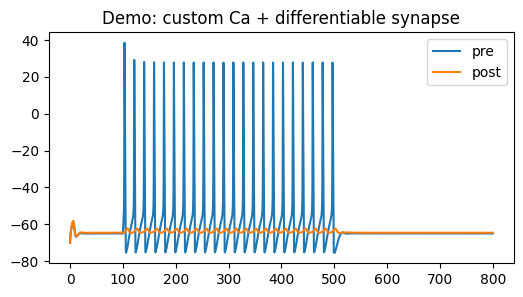

In [97]:
# Stimuli and simulation for Part 1
inputs_flat = [{"population": 0, "delay_ms": 100.0, "duration_ms": 400.0, "amplitude_A": 4e-12}]
currents = pulses_to_currents(inputs_flat, dt_ms=0.05, t_max_ms=800.0, out_unit="nA")
data_stimuli = net.cell(0).branch(0).comp(0).data_stimulate(jnp.asarray(currents[0], dtype=jnp.float32), None)
V = jx.integrate(net, delta_t=0.05, t_max=800.0, data_stimuli=data_stimuli)

t = np.arange(0.0, 800.0 + 0.05, 0.05)
plt.figure(figsize=(6,3))
plt.plot(t, V[0], label='pre')
plt.plot(t, V[1], label='post')
plt.legend(); plt.title('Demo: custom Ca + differentiable synapse'); plt.show()


## Part 2: Connectome Translation

We translate from c302 NeuroML into an intermediate spec and then into a Jaxley network. This applies unit conversions and maps parameters to the custom mechanisms defined above.


### Part 2.1: Translate NeuroML to an intermediate spec

We generate a c302 preset, parse NeuroML subset "Syns:B" into a structured `NetworkSpec`, and apply defaults. To parse and visualize the full network, change the preset to "Full"


In [98]:
# Load and translate a preset (level C)

from c302 import c302_Syns
cells, stim_cells, params, _, nml_doc = c302_Syns.setup("B", generate=True, target_directory="examples")

inter = load_c302_preset_to_intermediate("Syns:B")  # or "Syns:B" for gaps too
inter = apply_meta_defaults(inter, meta_policy_from_bioparams(inter.meta))


c302      >>>   - Ignoring inherited param: BioParameter: neuron_to_neuron_elec_syn_gbase = 0nS (SRC: BlindGuess, certainty 0.1)
c302      >>>   - Ignoring inherited param: BioParameter: neuron_to_muscle_elec_syn_gbase = 0nS (SRC: BlindGuess, certainty 0.1)
c302      >>>   - Ignoring inherited param: BioParameter: elec_syn_erev = 0mV (SRC: BlindGuess, certainty 0.1)
c302      >>>   - Ignoring inherited param: BioParameter: elec_syn_rise = 3ms (SRC: BlindGuess, certainty 0.1)
c302      >>>   - Ignoring inherited param: BioParameter: elec_syn_decay = 10ms (SRC: BlindGuess, certainty 0.1)
c302      >>>   - Ignoring inherited param: BioParameter: neuron_to_neuron_elec_syn_gbase = 0nS (SRC: BlindGuess, certainty 0.1)
c302      >>>   - Ignoring inherited param: BioParameter: neuron_to_muscle_elec_syn_gbase = 0nS (SRC: BlindGuess, certainty 0.1)
c302      >>>   - Ignoring inherited param: BioParameter: elec_syn_erev = 0mV (SRC: BlindGuess, certainty 0.1)
c302      >>>   - Ignoring inherited p

### Part 2.2: Build a Jaxley network from the intermediate spec

We convert to Jaxley parameters, build the network, and visualize a 2D projection with synapses.


Building cell 0 of 8 AIZL
Edges: 5
Building edge 0 of 5 VD12->VB11:chem:NC_VD12_VB11_GABA:neuron_to_neuron_inh_syn:0
Cells: 8  Connections: 5


Text(0, 0.5, 'y (µm)')

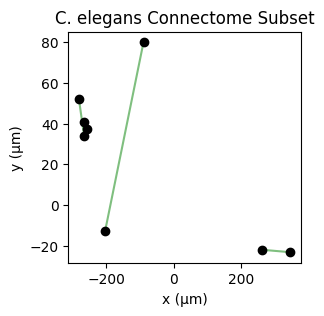

In [ ]:
bundle = translate_intermediate_to_jaxley_params(inter)
built = build_jaxley_from_params(inter, bundle, fast=False)

print(f"Cells: {len(inter.cells)}  Connections: {len(inter.conns)}")

ax = built.net.vis(
    detail="point", dims=(1, 2),
    color="k", synapse_color="g",
    synapse_scatter_kwargs={"s": 10, "alpha": 0.7, "zorder": -1},
    synapse_plot_kwargs={"alpha": 0.5, "zorder": -1}
)
ax.set_title("C. elegans Connectome Subset ", fontsize=12)
ax.set_xlabel('x (µm)'); ax.set_ylabel('y (µm)')


## Part 3: Simulation and Optimization

We’ll stimulate a small subset of neurons from the c302 inputs and optimize a synaptic parameter with a simple loss.


## Internals: Solver and stability

- Time-stepping uses exact updates for first-order linear gates: `exponential_euler / solve_inf_gate_exponential` with `save_exp` to avoid overflow.
- Stability tips:
  - Guard small denominators (taus, deltas) with `jnp.maximum`.
  - Use physiologically plausible bounds for gS, taus, thresholds.
  - Clip voltages in the loss and use `jnp.nan_to_num` to prevent NaN propagation.


### Part 3.1: Stimulus preparation and recording selection

We prepare currents from c302 inputs, attach them via `data_stimulate`, and choose a few cells to record from.


In [100]:
# Sim window
dt = 0.05
t_max = 800.0

# Pick a few populations (cell IDs) to stimulate
pop_ids = list(built.id_to_index.keys())[:2]  # e.g., ['URYDL','SMDDR']

# Define pulses (amplitude in A; here 20 pA)
inputs_flat = [
    {"population": pop_ids[0], "delay_ms": 100.0, "duration_ms": 400.0, "amplitude_A": 2e-11},
    {"population": pop_ids[1], "delay_ms": 300.0, "duration_ms": 300.0, "amplitude_A": 2e-11},
]

# Build currents in nA (no extra scaling)
currents = pulses_to_currents(inputs_flat, dt_ms=dt, t_max_ms=t_max, out_unit="nA", amp_scale=1.0)

# Attach to the network
data_stimuli, idxs = attach_currents_via_datastim(built.net, built.id_to_index, currents)

# Record and run
try: built.net.delete_recordings()
except: pass
for i in [idx for idx in idxs if idx is not None]:
    built.net.cell(i).branch(0).loc(0.0).record("v")


if hasattr(built.net, "delete_recordings"):
    built.net.delete_recordings()
for i in idxs[:5]:
    built.net.cell(i).branch(0).loc(0.0).record("v")



Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


### Part 3.2: Integrate and visualize

We integrate the built network with attached stimuli and visualize a few recorded voltages.


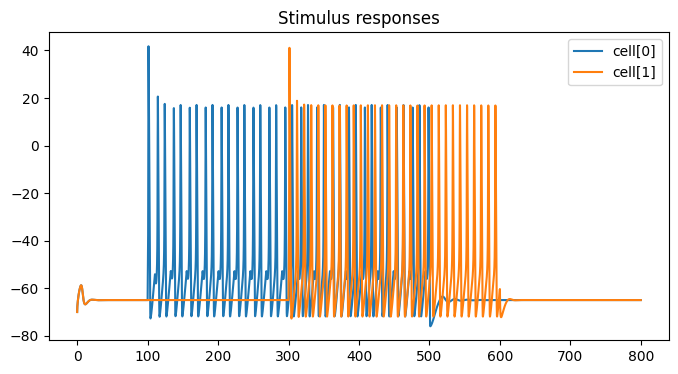

In [101]:
V = jx.integrate(built.net, delta_t=dt, t_max=t_max, data_stimuli=data_stimuli)

t = np.arange(0.0, t_max + dt, dt)
plt.figure(figsize=(8,4))
for k in range(min(5, V.shape[0])):
    plt.plot(t, V[k], label=f"cell[{k}]")
plt.legend(); plt.title("Stimulus responses"); plt.show()


### Data I/O: Stimuli and recordings

- `pulses_to_currents`: converts flattened c302 pulses into per-population traces (choose `out_unit="nA"`).
- `attach_currents_via_datastim`: attaches np arrays directly to compartments with `data_stimulate`.
- Recording:
  - Use `.record("v")` or bare `.record()` per location. Access via `.recordings` or capture returned array from `integrate`.
  - Recommended: clear prior recordings with `net.delete_recordings()` when iterating.


We define a loss function over the voltages and optimize the input stimulus, using gradients through the network.

### Optimizing the Input

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Gradient Wrt Inputs: [[-50.472347  -49.602486  -49.31517   ...  -0.9892569  -0.5000155
    0.       ]
 [-11.322984  -11.29361   -11.41031   ...  -0.9854086  -0.5000155
    0.       ]]


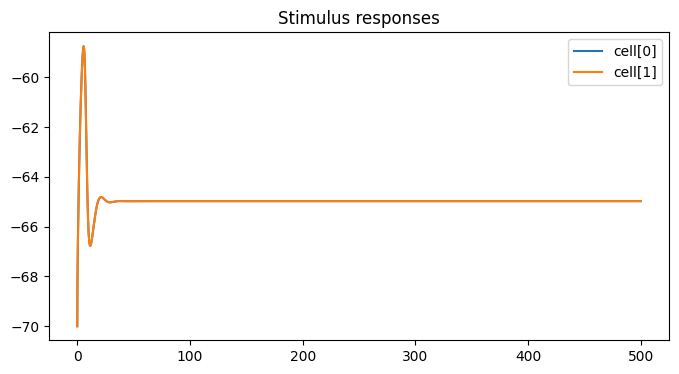

step 0  loss=4216.710809
Gradient Wrt Inputs: [[-1.8118166  -1.2681397  -0.75288457 ... -0.5275911  -0.32451192
   0.        ]
 [-3.094511   -2.5086083  -1.9600201  ... -0.9075659  -0.47106034
   0.        ]]


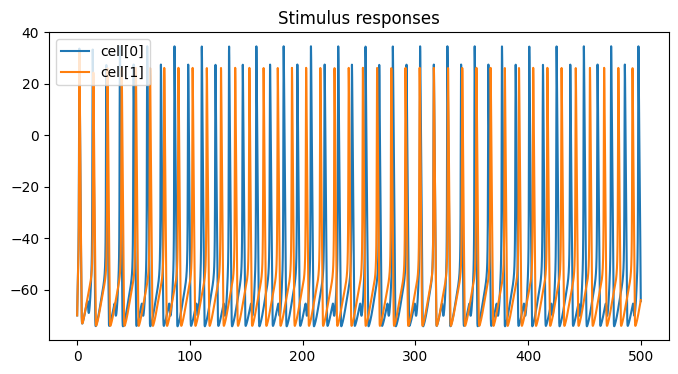

step 1  loss=3568.894714
Gradient Wrt Inputs: [[ 2.7764125   2.9164398   3.082116   ... -0.07851646 -0.05839551
   0.        ]
 [ 4.753897    4.9748526   5.222645   ... -0.83315074 -0.43989447
   0.        ]]


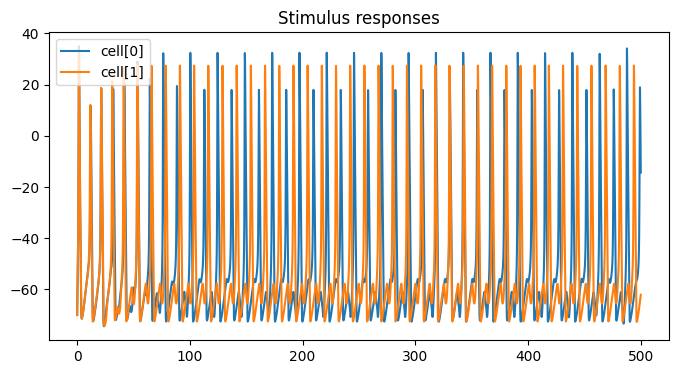

step 2  loss=3351.714836
Gradient Wrt Inputs: [[ 2.17499042e+00  2.40075898e+00  2.62882495e+00 ... -1.51540264e-01
  -1.03555761e-01  0.00000000e+00]
 [-1.35955551e+02 -1.28992477e+02 -1.23290794e+02 ... -7.82189012e-01
  -4.23876047e-01  0.00000000e+00]]


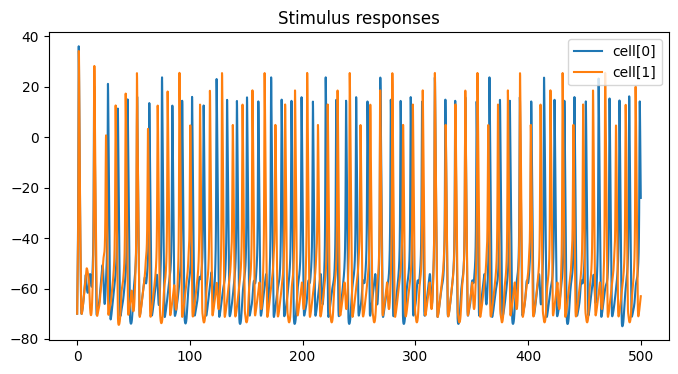

step 3  loss=3090.486394
Gradient Wrt Inputs: [[-5.707616   -4.670122   -3.8066723  ... -0.757497   -0.41921943
   0.        ]
 [ 0.7612982   1.0862314   1.394232   ... -0.6971736  -0.39966047
   0.        ]]


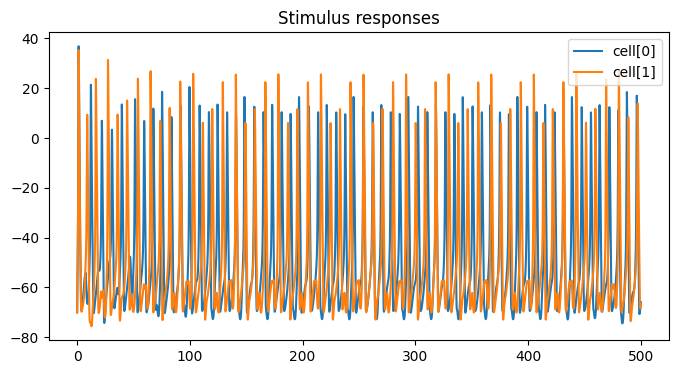

step 4  loss=3011.288617
Gradient Wrt Inputs: [[-8.643093   -7.68701    -6.840991   ... -0.73349655 -0.40330032
   0.        ]
 [-0.18733743  0.17902729  0.5166149  ... -0.6822565  -0.38758552
   0.        ]]


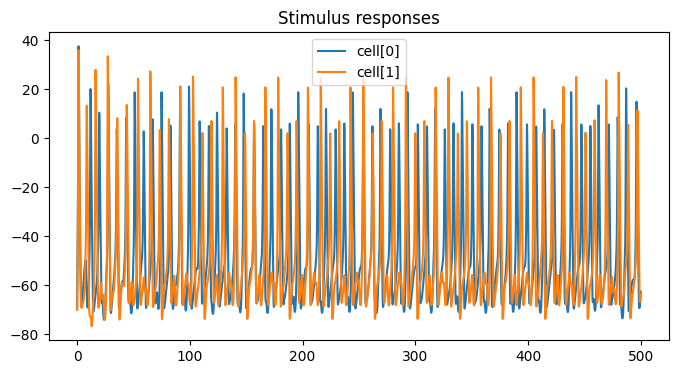

step 5  loss=2915.830221
Gradient Wrt Inputs: [[13.137181   12.584313   12.120797   ... -0.70190674 -0.3863009
   0.        ]
 [-0.43369025 -0.05798325  0.2841423  ... -0.6337985  -0.36826894
   0.        ]]


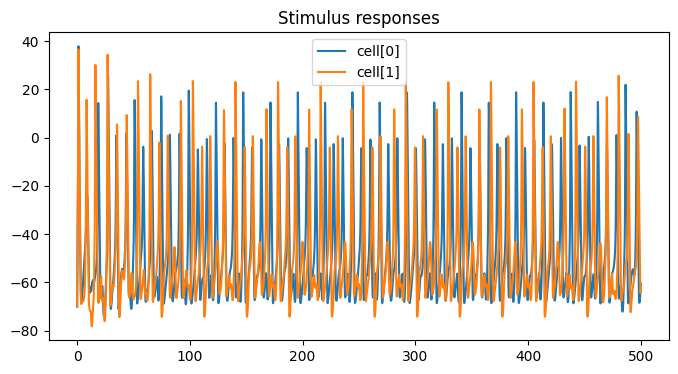

step 6  loss=2791.131188
Gradient Wrt Inputs: [[ 7.3202343   7.1189575   6.9552526  ... -0.6709887  -0.37036428
   0.        ]
 [-0.52047735 -0.14180583  0.20027216 ... -0.55917436 -0.33259714
   0.        ]]


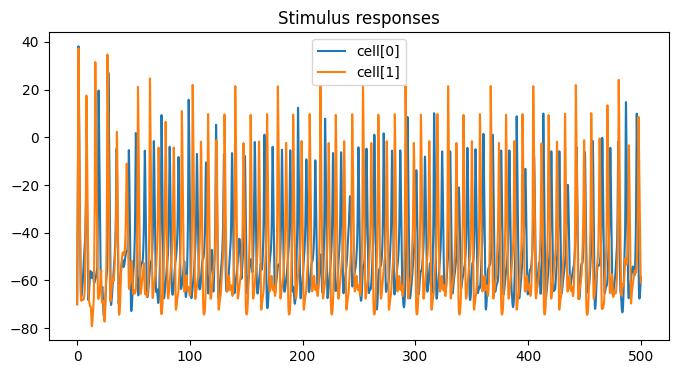

step 7  loss=2713.569025
Gradient Wrt Inputs: [[ 3.8661447   3.9352267   4.007079   ... -0.6404942  -0.35457078
   0.        ]
 [-0.57170266 -0.19144508  0.14997256 ... -0.49043816 -0.29383686
   0.        ]]


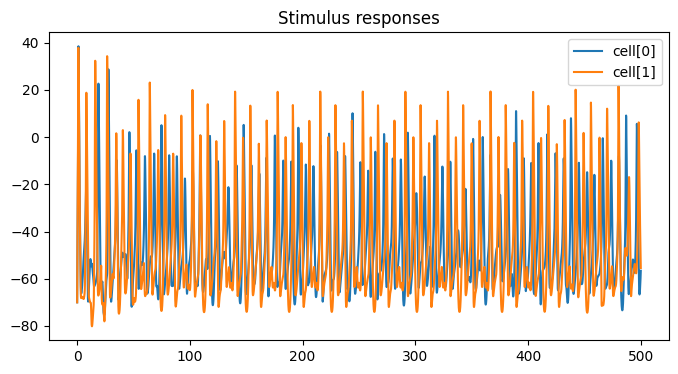

step 8  loss=2656.740771
Gradient Wrt Inputs: [[ 1.2891866e+01  1.1924843e+01  1.1107033e+01 ... -6.1081439e-01
  -3.3857095e-01  0.0000000e+00]
 [-5.9815961e-01 -2.1655513e-01  1.2431305e-01 ... -8.9402208e-03
  -8.2350699e-03  0.0000000e+00]]


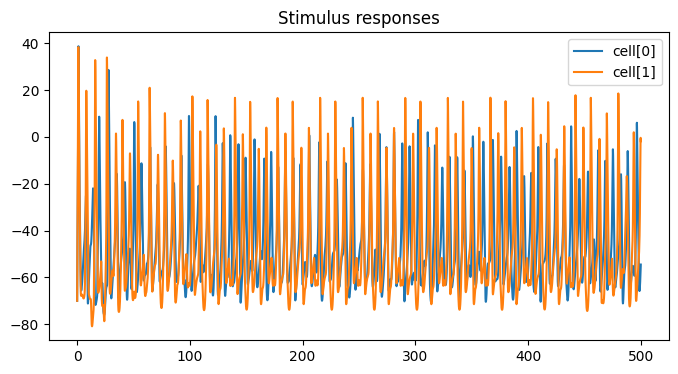

step 9  loss=2617.487528


In [102]:
import jax
import jax.numpy as jnp
import optax

# Choose dt/t_max consistent with your run
dt = 0.05
t_max = 500.0
T = int(t_max / dt) + 1
I_max_nA = 1  # 20 pA


# Pick a cell index to stimulate/record
stim_idxs = list(built.id_to_index.values())[:2]

# Clear recordings and add new ones
try: built.net.delete_recordings()
except: pass
for i in stim_idxs:
    built.net.cell(i).branch(0).loc(0.0).record("v")

# Build a combined template once (indices fixed), array will be replaced each step
ds = None
for i in stim_idxs:
    ds = built.net.cell(i).branch(0).comp(0).data_stimulate(jnp.zeros(T, dtype=jnp.float32), ds)
state_name, _, inds = ds  # ('i', zeros[2,T], DataFrame)

# Optimization variable: z -> tanh -> currents (2,T)
z0 = jnp.zeros((len(stim_idxs), T), dtype=jnp.float32)

def simulate_with_stim(z):
    I = I_max_nA * jnp.tanh(z)            # bounded nA, shape (2,T)
    ds_now = (state_name, I, inds)        # reuse indices, swap only array
    V = jx.integrate(built.net, delta_t=dt, t_max=t_max, data_stimuli=ds_now)
    return V

@jax.jit
def loss_fn(z):
    V = simulate_with_stim(z)
    # Mean squared voltage across both recorded/stim cells
    mse = jnp.mean(V**2)
    # Tiny regularizer on current energy
    reg = 1e-4 * jnp.mean((I_max_nA * jnp.tanh(z))**2)
    return mse + reg, V

opt = optax.adam(1e-2)
z = z0
opt_state = opt.init(z)

def plot_voltage(V, t_max, dt):
    t = np.arange(0.0, t_max + dt, dt)
    plt.figure(figsize=(8,4))
    for k in range(min(5, V.shape[0])):
        plt.plot(t, V[k], label=f"cell[{k}]")
    plt.legend(); plt.title("Stimulus responses"); plt.show()


for step in range(10):
    ((val, V), grad) = jax.value_and_grad(loss_fn,has_aux=True)(z)
    print("Gradient Wrt Inputs: "+ str(grad))
    plot_voltage(V, t_max, dt)  # not (V, dt, t_max)
    updates, opt_state = opt.update(grad, opt_state)
    z = optax.apply_updates(z, updates)
    print(f"step {step}  loss={float(val):.6f}")

# Get the final current and voltage
stim_opt = I_max_nA * jnp.tanh(z)
V_opt = simulate_with_stim(z)

As we can see, loss (mean squared voltage in this case) decreases as the input is optimized. This can be extended to different loss functions decoded from network variables.